In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import numpy as np
import seaborn as sns
from ripser import ripser
import pandas as pd
import pickle
import time
import os
from scipy import signal as sp_signal
from scipy.stats import binned_statistic_2d
from scipy.stats import gaussian_kde
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

### One at a time

0it [00:00, ?it/s]

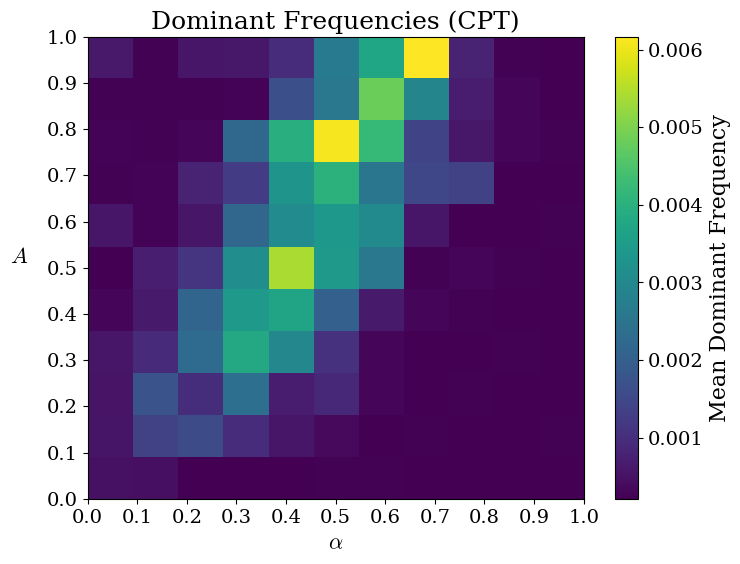

In [20]:
directory = "results_5"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        res = pickle.load(f)
    data.append((res["params"]["w_delta_scale"], res["params"]["alpha"], freqs[idx]))

# Convert to numpy arrays
w_delta_scale = np.array([d[0] for d in data])
alpha = np.array([d[1] for d in data])
freq_lists = [d[2] for d in data]  # each element is a list

# Define bins
bins = np.linspace(0, 1, 12)  # 11 bins → 12 edges

# Prepare an array to store the mean frequency per bin
heatmap = np.zeros((11, 11))

# Iterate over bins
for i in range(11):
    for j in range(11):
        # Find indices that fall into this bin
        idxs = np.where(
            (w_delta_scale >= bins[i]) & (w_delta_scale < bins[i+1]) &
            (alpha >= bins[j]) & (alpha < bins[j+1])
        )[0]
        
        # Concatenate all lists of freqs in this bin
        if len(idxs) > 0:
            combined_freqs = np.concatenate([freq_lists[k] for k in idxs])
            heatmap[i, j] = combined_freqs.mean()
        else:
            heatmap[i, j] = np.nan  # optional, for empty bins

plt.figure(figsize=(8,6))
im = plt.imshow(heatmap, origin='lower', 
                extent=[0,1,0,1], aspect='auto', 
                cmap='viridis')
plt.colorbar(im, label='Mean Dominant Frequency')
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$A$', rotation=0, labelpad=20)
plt.title('Dominant Frequencies (CPT)')
plt.show()

In [22]:
directory = "cpt_no_effect"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        res = pickle.load(f)
    data.append((res["params"]["w_delta_scale"], res["params"]["alpha"], freqs[idx]))

0it [00:00, ?it/s]

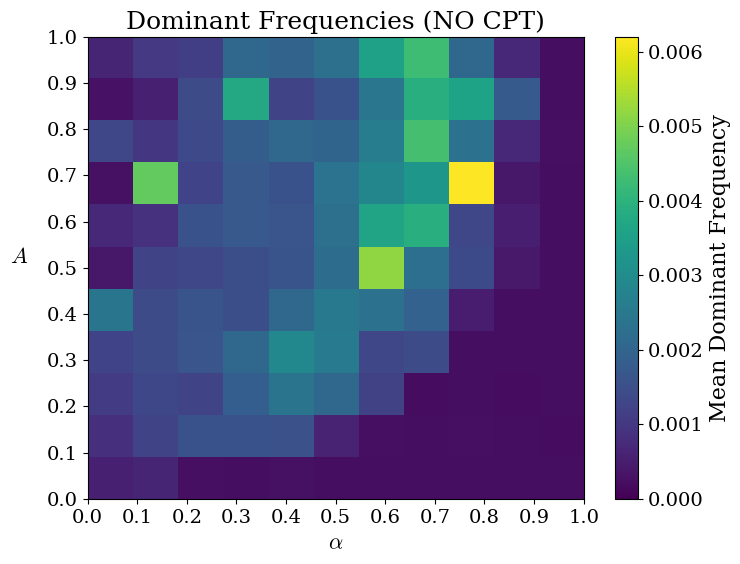

In [25]:
## Convert to numpy arrays
w_delta_scale = np.array([d[0] for d in data])
alpha = np.array([d[1] for d in data])
freq_lists = [d[2] for d in data]  # each element is a list

# Define bins
bins = np.linspace(0, 1, 12)  # 11 bins → 12 edges

# Prepare an array to store the mean frequency per bin
heatmap = np.zeros((11, 11))

# Iterate over bins
for i in range(11):
    for j in range(11):
        # Find indices that fall into this bin
        idxs = np.where(
            (w_delta_scale >= bins[i]) & (w_delta_scale < bins[i+1]) &
            (alpha >= bins[j]) & (alpha < bins[j+1])
        )[0]
        
        # Concatenate all lists of freqs in this bin
        if len(idxs) > 0:
            combined_freqs = np.concatenate([freq_lists[k] for k in idxs])
            heatmap[i, j] = combined_freqs.mean()
        else:
            heatmap[i, j] = np.nan  # optional, for empty bins

plt.figure(figsize=(8,6))
im = plt.imshow(heatmap, origin='lower', 
                extent=[0,1,0,1], aspect='auto', 
                cmap='viridis', 
                vmin=0, vmax=0.0062)
plt.colorbar(im, label='Mean Dominant Frequency')
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$A$', rotation=0, labelpad=20)
plt.title('Dominant Frequencies (NO CPT)')
plt.show()

## All Heatmaps

In [6]:
directory = "results_5"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

0it [00:00, ?it/s]

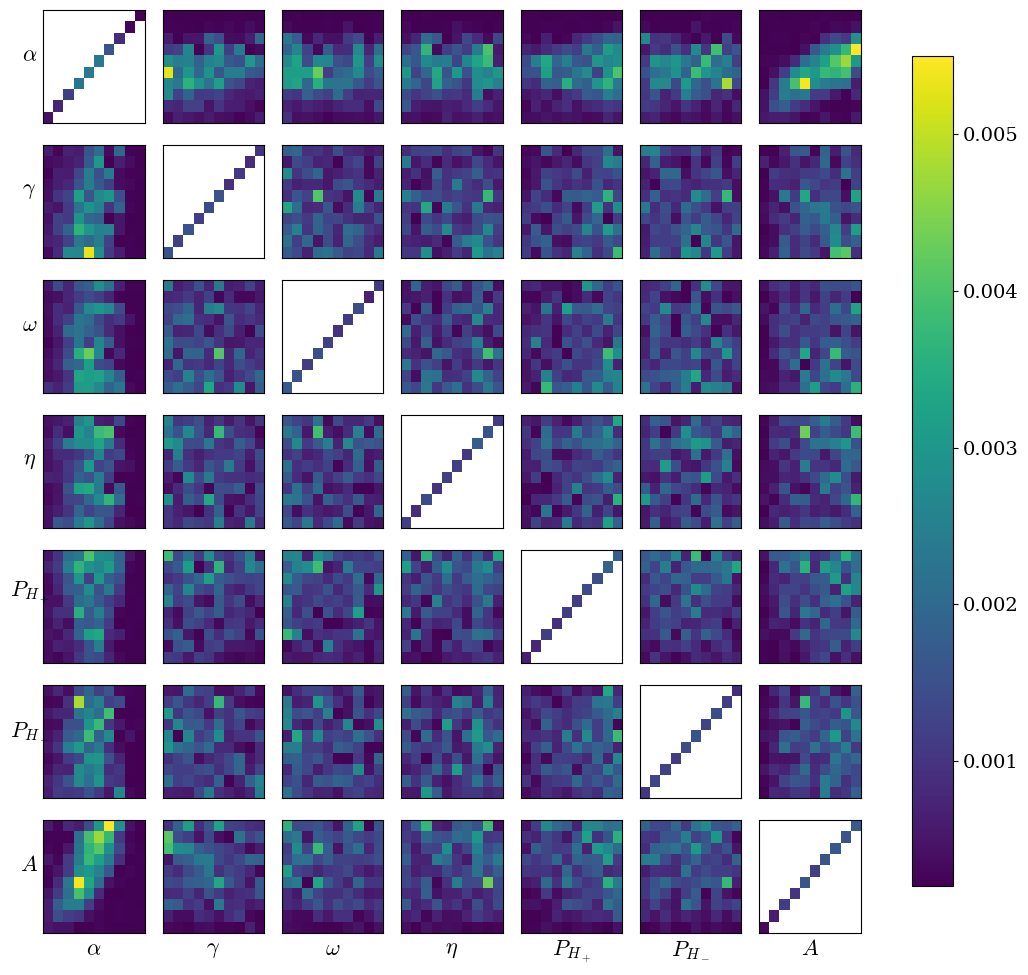

In [73]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

map_vals = []

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    combined_freqs = np.concatenate([freq_lists[k] for k in idxs])
                    heatmap[a, b] = combined_freqs.mean()
                else:
                    heatmap[a, b] = np.nan

                

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0002, vmax=0.0055)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=10)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()